In [1]:
#Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.metrics import *
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras import backend as K
from imgaug import augmenters
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [2]:
#Reading the training and testing dataset
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
#Reshape data
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

#Normalize data between 0 and 1
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28, 1) (60000,)
Testing data shape :  (10000, 28, 28, 1) (10000,)


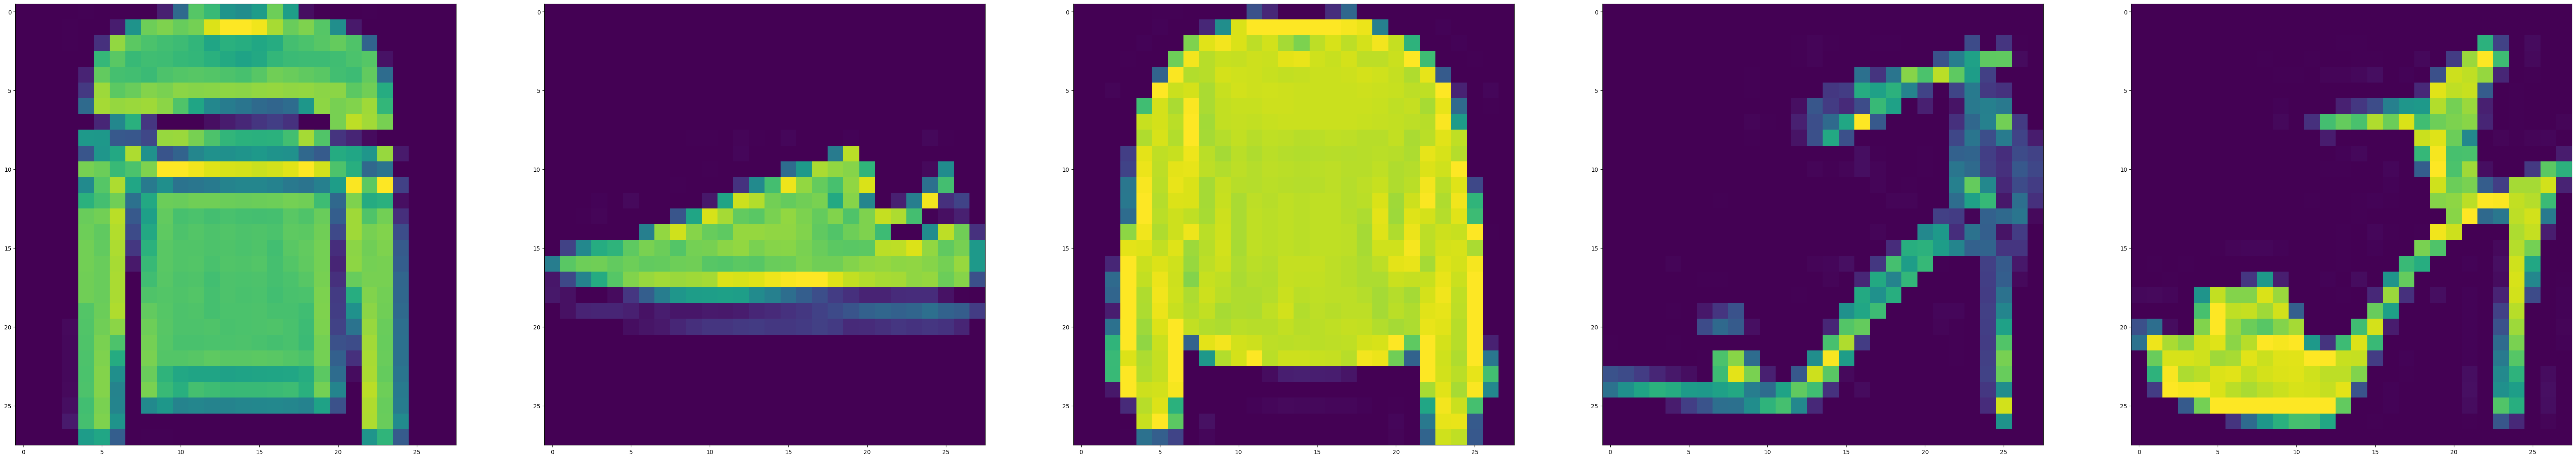

In [4]:
#Visualize 10 images from dataset
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_X[i, :, :, 0].reshape(28, 28))
plt.show()

In [5]:
#Split the training and testing data into 80 and 20 configuration
from sklearn.model_selection import train_test_split
train_X,valid_X = train_test_split(train_X, test_size=0.2, random_state=13)

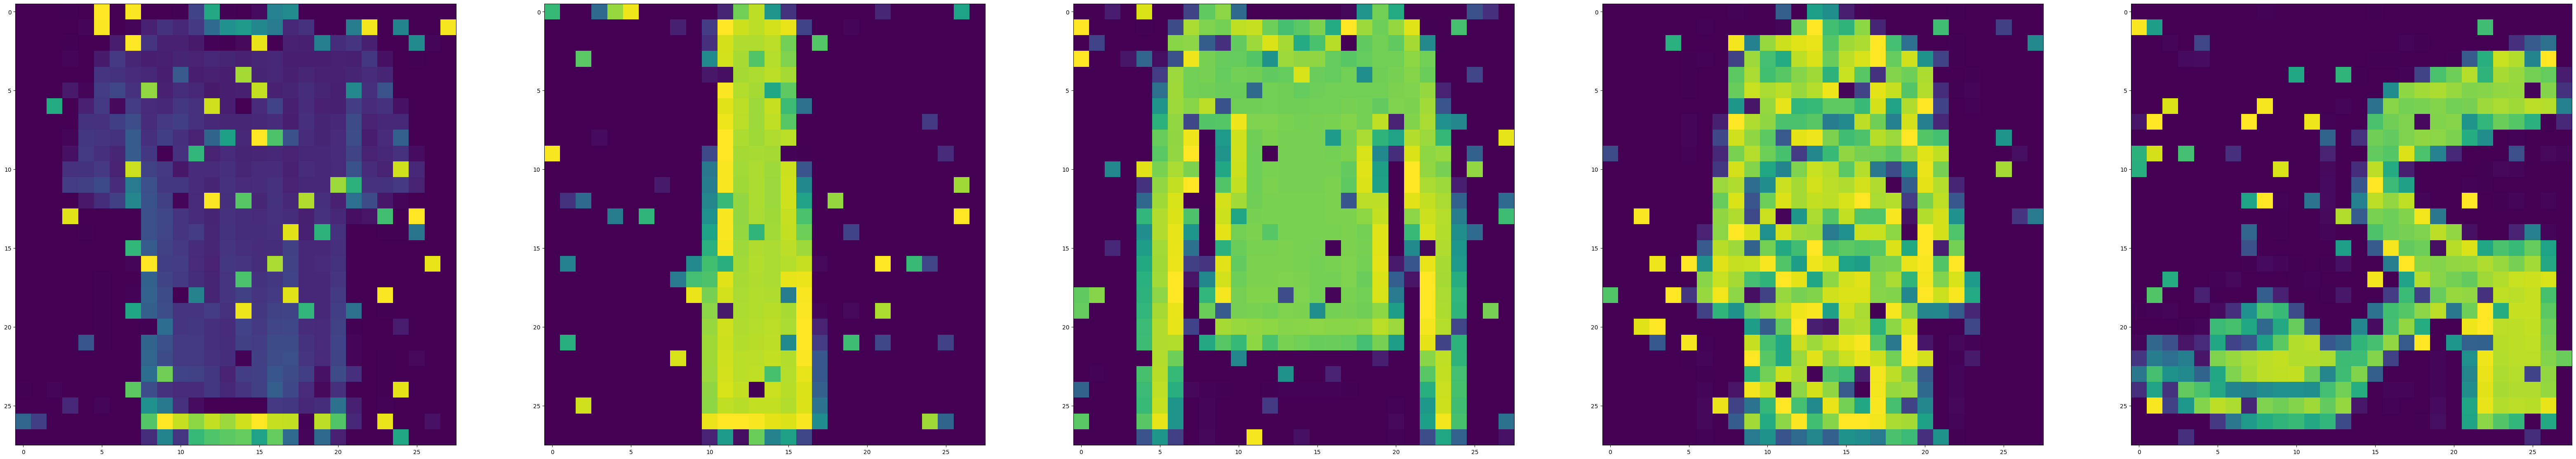

In [6]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_X_n = seq_object.augment_images(train_X * 255) / 255
valid_X_n = seq_object.augment_images(valid_X * 255) / 255
test_X_n = seq_object.augment_images(test_X * 255) / 255

#Visualize 10 images from dataset with noise
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_X_n[i, :, :, 0].reshape(28, 28))
plt.show()

In [7]:
# input layer
input_layer = Input(shape=(28, 28, 1))

In [8]:
# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

In [9]:
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

In [10]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_X_n, train_X, epochs=5, batch_size=2048, validation_data=(valid_X_n, valid_X), callbacks=[early_stopping])

Epoch 1/5
24/24 [==============================] - 238s 10s/step - loss: 0.0948 - val_loss: 0.0577
Epoch 2/5
24/24 [==============================] - 212s 9s/step - loss: 0.0455 - val_loss: 0.0375
Epoch 3/5
24/24 [==============================] - 199s 8s/step - loss: 0.0344 - val_loss: 0.0313
Epoch 4/5
24/24 [==============================] - 198s 8s/step - loss: 0.0295 - val_loss: 0.0277
Epoch 5/5
24/24 [==============================] - 199s 8s/step - loss: 0.0266 - val_loss: 0.0253


1/1 [==============================] - 0s 214ms/step


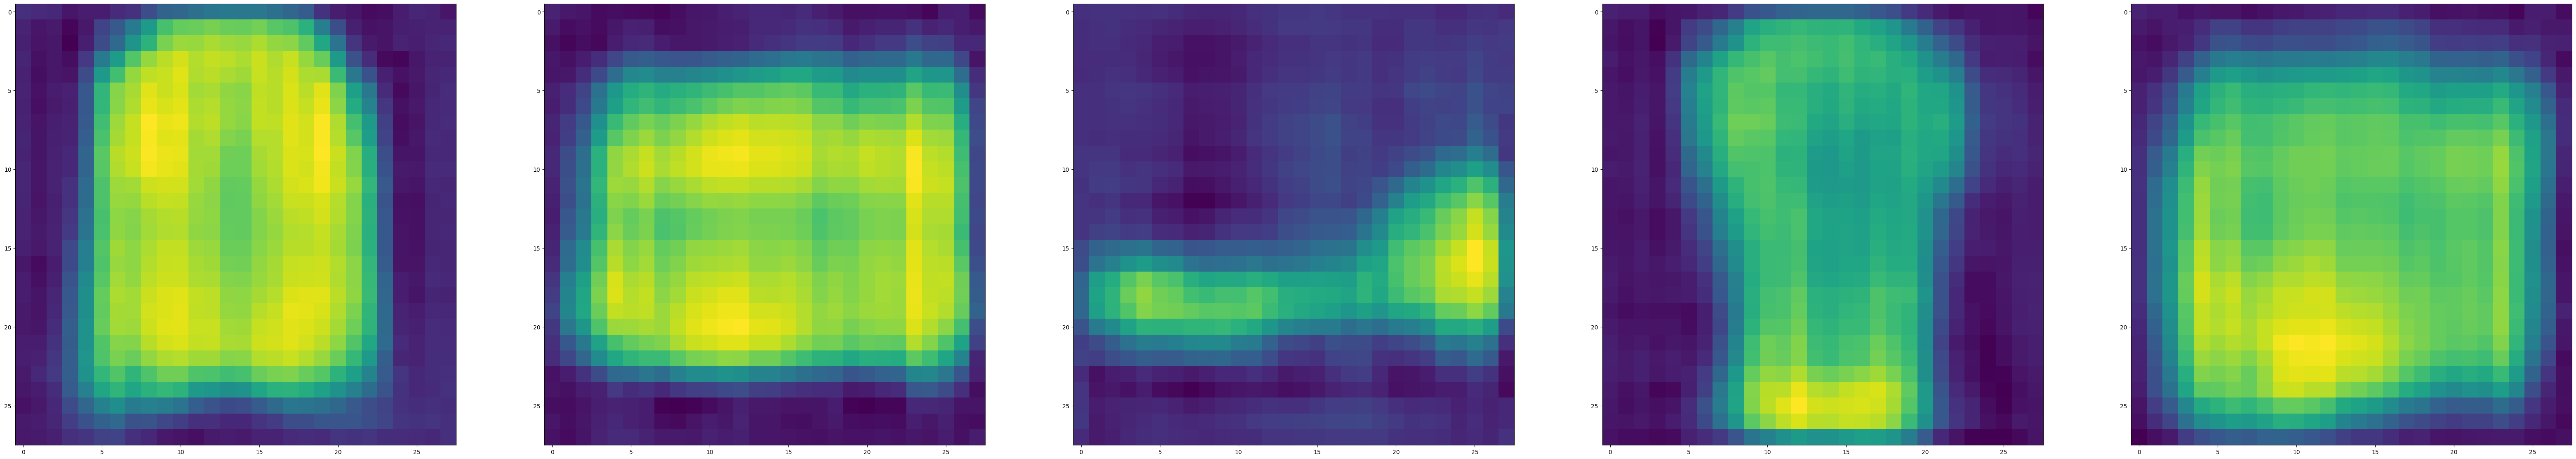

In [12]:
n = np.random.randint(0,len(test_X)-5)

preds = model.predict(test_X_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

### Question 6: Display the images before and after noise has been removed from them. (NOTE: The above code can be used to only display the images are denoising. Write the code to display their counterpart images with noise)


1/1 [==============================] - 0s 39ms/step


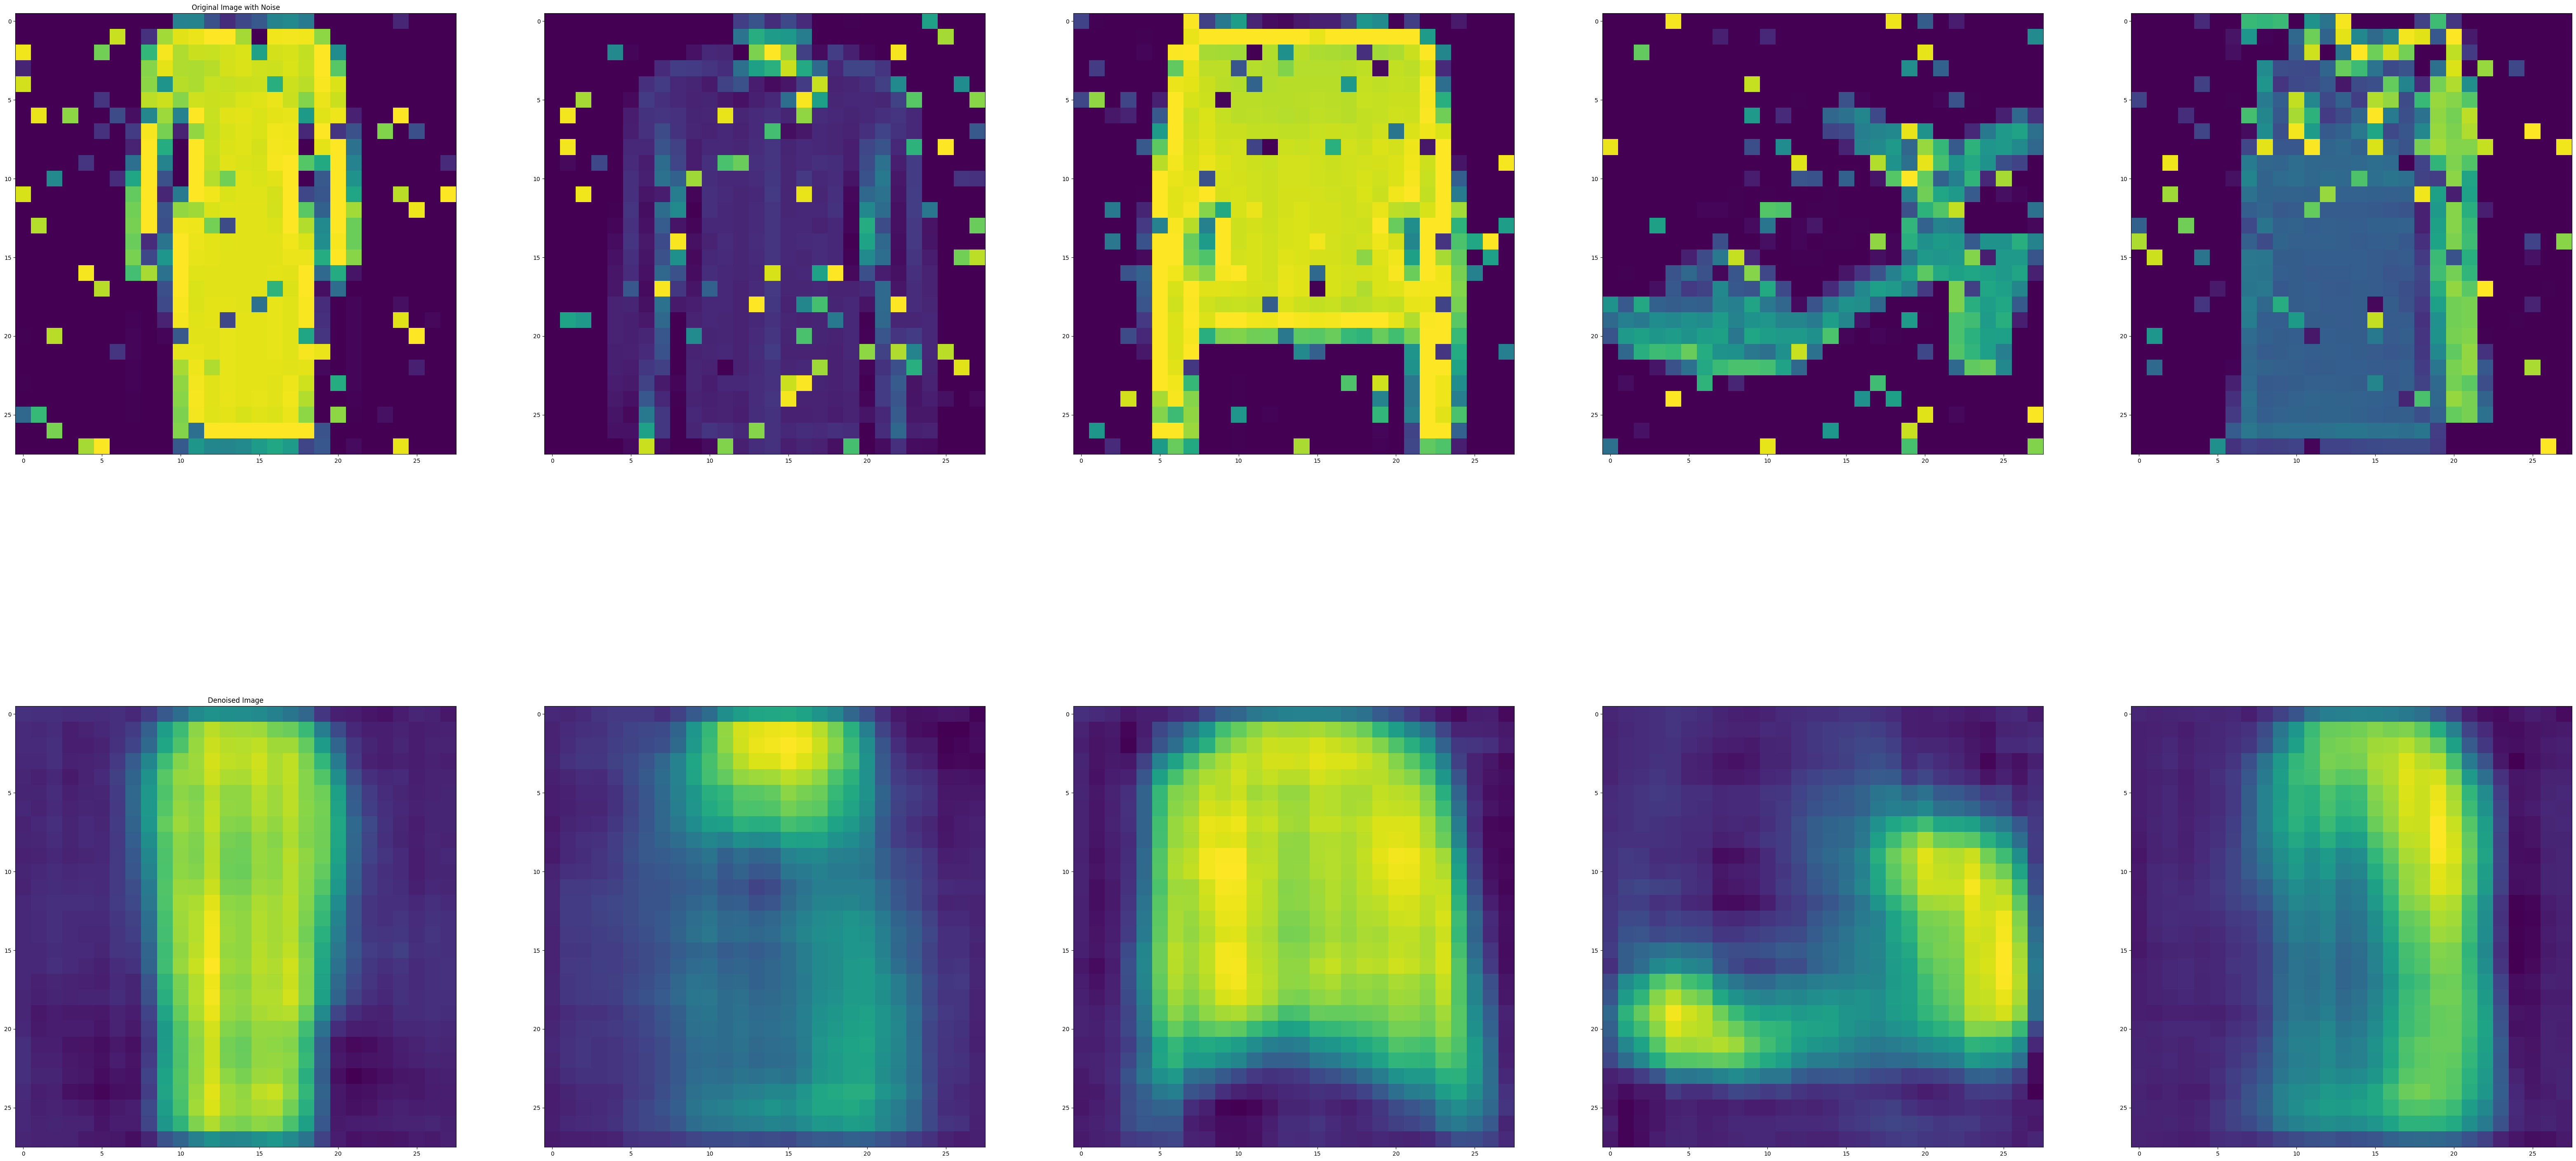

In [13]:
# Generate random index
n = np.random.randint(0, len(test_X)-5)

# Get the original images with noise
noisy_images = test_X_n[n:n+5]

# Get the denoised images
denoised_images = model.predict(noisy_images)

# Create subplots to display images
fig, axes = plt.subplots(2, 5)
fig.set_size_inches(80, 40)

# Display original images with noise
for i, ax in enumerate(axes[0]):
    ax.imshow(noisy_images[i].reshape(28, 28))

# Display denoised images
for i, ax in enumerate(axes[1]):
    ax.imshow(denoised_images[i].reshape(28, 28))

# Set titles for subplots
axes[0, 0].set_title("Original Image with Noise")
axes[1, 0].set_title("Denoised Image")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)

# Show the plot
plt.show()

### The End of the notebook